In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
import scipy.signal
import logging
import time

from lisagwresponse import GalacticBinary
from lisainstrument import Instrument

from pytdi import Data
from pytdi import michelson as mich
from pytdi import ortho

from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn

import os

In [2]:
# orbit_path = '../orbits/keplerianupsampled.h5'
# orbit_path = '../orbits/kep-1hz30d.h5'
orbit_path = '../orbits/keplerian_long.h5'
gw_path = 'gws.h5'

# Setup simluation parameters
fs = 0.1    # Hz
day = 86400 # s
duration = day # X days
size = duration*fs
discard = 300

rec = ['A','E','T']

with h5py.File(orbit_path) as orbits:
    orbits_t0 = orbits.attrs['t0']
    orbit_fs = 1/orbits.attrs['dt']
    orbit_dur = orbits.attrs['tsize']/orbit_fs
    print ("fs = "+str(fs)+" Hz,  orbit_duration = "+str(orbit_dur/day)+" d")


# True values of inserted parameters
Amp_true = 5e-17
f_true = 1e-3
phi0_true = 0

fs = 0.1 Hz,  orbit_duration = 1500.0 d


In [3]:
# Setup galactic binary to insert in simulation
# if os.path.exists(gw_path):
#     os.remove(gw_path)

# #source = GalacticBinary(A=6.4e-23, f=6.22e-3, orbits=orbit_path, t0=orbits_t0+10, gw_beta=0,gw_lambda=0) #HM Cnc
# source = GalacticBinary(A=Amp_true, f=f_true, phi0=phi0_true, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=0, gw_lambda=0, dt=1/fs, size=size+300)
# #source = GalacticBinary(A=5E-20, f=1E-2, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=0, gw_lambda=0)
# #source = GalacticBinary(A=1E-16, f=1E-2, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=0, gw_lambda=0) #ridiculously loud binary

# source.write(gw_path)

In [4]:
# Setup logger (sometimes useful to follow what's happening)

# logging.basicConfig()
# logging.getLogger('lisainstrument').setLevel(logging.INFO)

In [5]:
# Create 'realistic' orbit with signal and noise

# sample_instru = Instrument(
#     size=size, # in samples
#     dt=1/fs,
#     aafilter=('kaiser', 240, 0.275*fs, 0.725*fs),
#     orbits=orbit_path, # realistic orbits (make sure it's consistent with glitches and GWs!)
#     gws=gw_path
# )
# sample_instru.disable_all_noises()
# sample_instru.simulate()

In [6]:
# Write out data to sample file
# NOTE: Remember to remove the old sample file.

# outputf = 'measurements/MCMCsample'+str(int(duration))+'s.h5'

# if os.path.exists(outputf):
#     os.remove(outputf)

# sample_instru.write(outputf)


In [7]:
# Read data from LISA Instrument

# rawdata = Data.from_instrument('measurements/MCMCsample'+str(int(duration))+'s.h5')

# t0 = time.time()
# A = ortho.A2.build(**rawdata.args)(rawdata.measurements)[discard:]
# t1 = time.time()
# print ("Time to build and run A2 = "+str(t1-t0))
# E = ortho.E2.build(**rawdata.args)(rawdata.measurements)[discard:]
# t2 = time.time()
# print ("Time to build and run E2 = "+str(t2-t1))
# T = ortho.T2.build(**rawdata.args)(rawdata.measurements)[discard:]
# t3 = time.time()
# print ("Time to build and run T2 = "+str(t3-t2))

# #t = sample_instru.t[discard:]
# t = (np.arange(0,len(A)+discard)/fs)[discard:]

# sdata = np.array([t,A,E,T])

# # Extract A, E, T data to speed up re-running code.
# filepath = 'measurements/MCMCsample'+str(int(duration))+'s.txt'
# filecontent = Table(sdata.T, names=['t','A','E','T'])
# ascii.write(filecontent, filepath, overwrite=True)

# t4 = time.time()
# print ("Total time = "+str(t4-t0))

In [8]:
# Retreive A, E, T data
rawdata = ascii.read('measurements/MCMCsample'+str(int(duration))+'s.txt')
sdata = np.array([rawdata['t'],rawdata['A'],rawdata['E'],rawdata['T']])

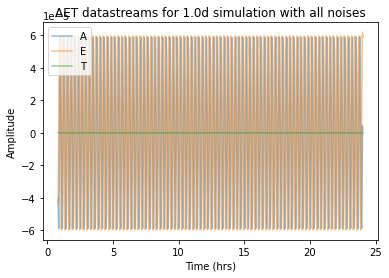

In [9]:
for i in range(3):
    plt.plot(sdata[0]/3600,sdata[i+1],label=rec[i],alpha=.5)
plt.title('AET datastreams for '+str(duration/day)+'d simulation with all noises')
plt.legend()
plt.xlabel('Time (hrs)')
plt.ylabel('Amplitude')
plt.show()

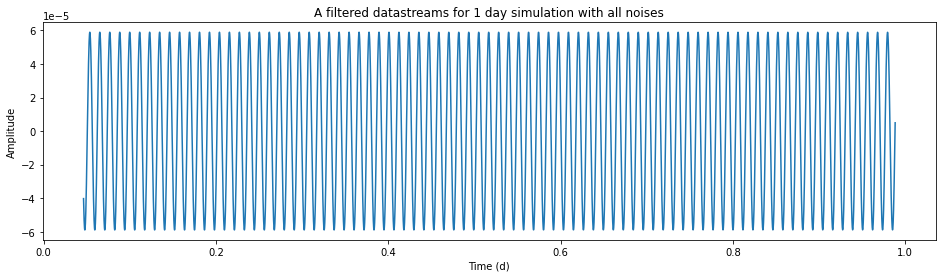

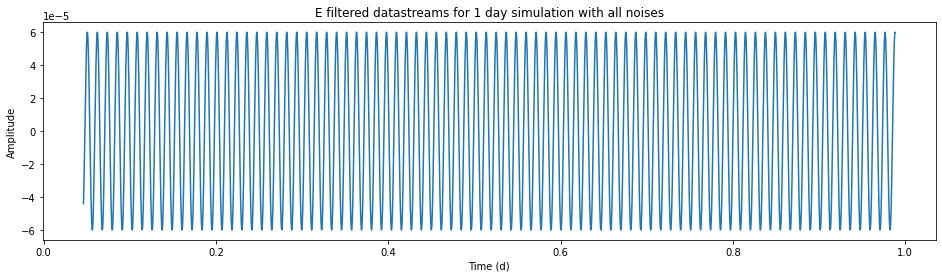

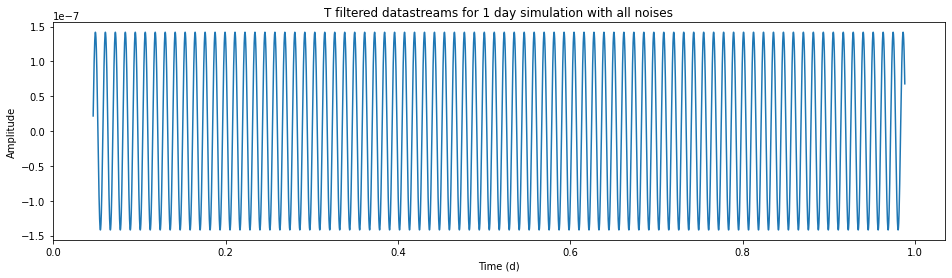

In [10]:
def psd_func(data):
    return scipy.signal.welch(data,fs=fs,window='nuttall',nperseg=len(data),detrend=False)

# Create psd for data
tmp = []
for i in range(1,4):
    ftmp, psdtmp = psd_func(sdata[i])
    tmp.append(psdtmp)
psd = np.array([ftmp,tmp[0],tmp[1],tmp[2]])


# Create filtered data
cutoff = 100
tmp = []
#coeffs = scipy.signal.firls(73,bands=[0,1,1.2,2],desired=[1,1,0,0],fs=fs)
#coeffs = scipy.signal.firls(73, bands=[0,1e-2,3e-2,5e-2], desired=[1,1,0,0],fs=fs)
coeffs = scipy.signal.firls(73, bands=[0,5e-3,1e-2,fs/2], desired=[1,1,0,0],fs=fs)
for i in range(1,4):
    fdata_tmp = scipy.signal.filtfilt(coeffs,1., x=sdata[i],padlen=len(psd[0]))
    tmp.append(fdata_tmp[cutoff:-cutoff])
fsdata = np.array([sdata[0][cutoff:-cutoff],tmp[0],tmp[1],tmp[2]])

# Create psd for filtered data
tmp = []
for i in range(1,4):
    ftmp, psdtmp = psd_func(fsdata[i])
    tmp.append(psdtmp)
fpsd = np.array([ftmp,tmp[0],tmp[1],tmp[2]])

for i in range(3):
    plt.figure(figsize=(16,4))
    plt.plot(fsdata[0]/day,fsdata[i+1])
    plt.title(rec[i]+' filtered datastreams for 1 day simulation with all noises')
    plt.xlabel('Time (d)')
    plt.ylabel('Amplitude')
    #plt.xlim(.25,1)
    plt.show()

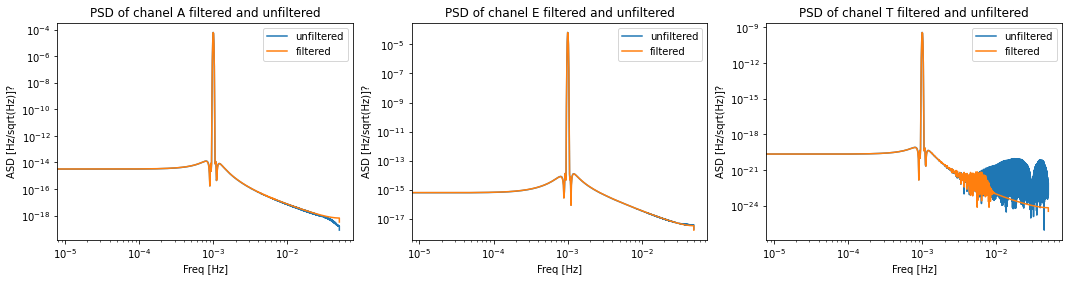

In [11]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(4)
fig.set_figwidth(18)
for i in range(3):
    axs[i].plot(psd[0],psd[i+1], label='unfiltered')
    axs[i].plot(fpsd[0],fpsd[i+1], label='filtered')
    axs[i].legend()
    axs[i].set_yscale('log')
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Freq [Hz]')
    axs[i].set_ylabel('ASD [Hz/sqrt(Hz)]?')
    axs[i].set_title("PSD of chanel "+rec[i]+' filtered and unfiltered')
plt.show()

In [12]:
# Difference factor between pytdi.Data.from_instrument and pytdi.Data.from_gws

def dphi_to_dnu(time,data,f_gw = f_true):
    laser_freq = 2.816E14 #Hz, gotten from lisainstrument code
    dt = 1/fs
    # dt = np.mean((time[1:]-time[:-1]))
    return np.diff(data) * ((laser_freq) / (2*np.pi*f_gw*dt))

In [13]:
# Define MCMC zero-conditions
theta_prior = np.array([
    [1e-22,1e-8],
    [1e-5,1e-2]
])
A_prior, f_prior = theta_prior

Amp_guess, f_guess = Amp_true, f_true

theta_guess = np.array([Amp_guess,f_guess])
theta_true = np.array([Amp_true,f_true])
print (theta_guess,theta_true)


[5.e-17 1.e-03] [5.e-17 1.e-03]


# Imshow of likelyhoods

In [14]:
# Generate random binary to be able to build the TDI chanels
GalBin = GalacticBinary(A=Amp_true, f=f_true,phi0=phi0_true, orbits=orbit_path ,t0=orbits_t0+10, gw_beta=0, gw_lambda=0,dt=1/fs,size=size+300)
GalBin.write('gw_tmp2.h5')
rawdata = Data.from_gws('gw_tmp2.h5',orbit_path,interpolate=True)

Afunc = ortho.A2.build(**rawdata.args)

os.remove('gw_tmp2.h5')



def model(st,sA, Amp, f_gw, phi0 = -0.4, t0=orbits_t0+10, gw_beta=0,gw_lambda=0):
    
    GalBin = GalacticBinary(A=Amp, f=f_gw, phi0=phi0, orbits=orbit_path, t0=t0, gw_beta=gw_beta, gw_lambda=gw_lambda, dt=1/fs, size=size+300)
    GalBin.write('gw_tmp2.h5')
    
    # rawdata = Data.from_gws( 'gw_tmp.h5', orbit_path)
    rawdata = Data.from_gws( 'gw_tmp2.h5', orbit_path,interpolate=True)
    mA = Afunc(rawdata.measurements)[discard:]
    #E = Efunc(rawdata.measurements)[discard:]
    # If we only fit signal parameters, we don't include T since it has by definition no signal.
    #T = Tfunc(rawdata.measurements)[discard:]
    
    mt = GalBin.t[discard:]
    
    os.remove('gw_tmp2.h5')
    
    # Generate correct amplitude to be compatible with sample data
    nmt = np.copy(mt)[:-1]
    nmA = dphi_to_dnu(mt,mA,f_gw)
    
    # Make sure that the model generates data at the correct time
    time_indices = np.where(np.in1d(nmt, st))[0]
    nnmt, nnmA = nmt[time_indices], nmA[time_indices]

    return np.array([nnmt,nnmA])
    # return np.array([t,A,E,T])

def lnL(theta, t, y):
    """
    The log likelihood of our simplistic Linear Regression. 
    """
    Amp, f = theta
    newt, y_model = model(t,y,*theta)
    
    return -0.5*(np.sum((y-y_model)**2))

def lnprior(theta):
    """
    Define a prior that allows the parameters between certain limits. Between the limits it is flat.     
    """
    Amp, f= theta
    
    if A_prior[0] < Amp < A_prior[1] and f_prior[0] < f < f_prior[1]:
        return 0.0
    return -np.inf

def lnprob(theta, t, y):
    """
    The likelihood to include in the MCMC.
    """
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp+lnL(theta, t, y)


In [15]:
print (lnprob([Amp_guess, f_guess],fsdata[0],fsdata[1]))
print (lnprob([Amp_guess, f_guess+0.001],fsdata[0],fsdata[1]))
print (lnprob([Amp_guess, f_guess-0.0001],fsdata[0],fsdata[1]))
print (lnprob([Amp_guess, f_guess+0.0001],fsdata[0],fsdata[1]))

print (lnL([Amp_true,f_true],fsdata[0],fsdata[1]))
print (f_true,Amp_true)

-4.937717770326636e-10
-0.00044859156345236314
-1.1019884628504416e-05
-1.987146457815387e-05
-4.937717770326636e-10
0.001 5e-17


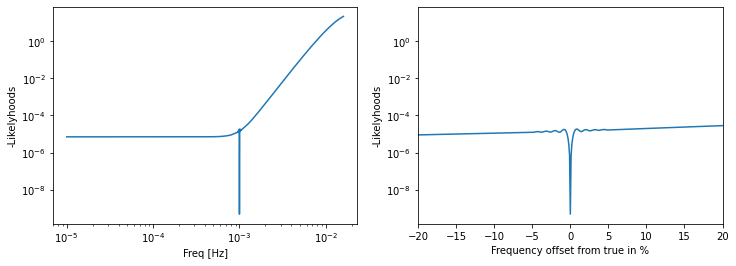

In [17]:
def likelyhoods_f(mkfile=False, tight=False, Ampl=Amp_true):
    # if mkfile=True, it recalculates everything, if False, it draws from filename
    filepath = 'measurements/likelyhoods_f.txt'
    
    if mkfile:
        if tight:
            f_vartmp = f_true + 1e-5*np.array(np.linspace(-5,5,101))
            likelyhoods = np.ones(len(f_vartmp))
        
            for i in range(len(f_vartmp)):
                likelyhoods[i] = lnL([Ampl,f_var[i]],fsdata[0],fsdata[1])
        else:
            f_vartmp = list(np.logspace(-5,-3.1,50))
            f_vartmp.extend(f_true + 1e-5*np.array(np.linspace(-5,5,101)))
            f_vartmp.extend(f_true + 1e-4*np.array(np.linspace(1,150,101)))
            likelyhoods = np.ones(len(f_vartmp))

            for i in range(len(f_vartmp)):
                likelyhoods[i] = lnL([Ampl,f_vartmp[i]],fsdata[0],fsdata[1])
        
        filecontent = Table([f_vartmp,likelyhoods],names=["f","L"])
        ascii.write(filecontent,filepath,overwrite=True)
        
    else:
        raw = ascii.read(filepath)
        f_vartmp = np.array(raw['f'])
        likelyhoods = np.array(raw['L'])
        
    return np.array([f_vartmp,likelyhoods])

f_var = likelyhoods_f(mkfile=True)

fig, axs = plt.subplots(1,2)
fig.set_figwidth(12)
fig.set_figheight(4)
axs[0].loglog(f_var[0],-f_var[1])
axs[0].set_xlabel("Freq [Hz]")
axs[0].set_ylabel("-Likelyhoods")
axs[1].semilogy((f_var[0]-f_true)/f_true*100,-f_var[1])
axs[1].set_xlim(-20,20)
axs[1].set_xlabel("Frequency offset from true in %")
axs[1].set_ylabel("-Likelyhoods")
plt.show()


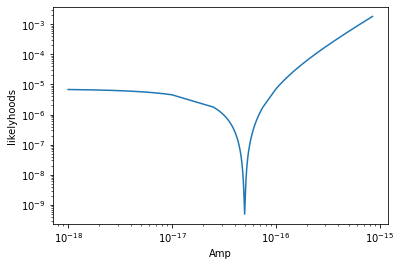

In [18]:
def likelyhoods_Amp(newdat = False, mkfile=False, tight=False,freq = f_true):
    # if mkfile=True, it recalculates everything, if False, it draws from filename
    filepath = 'measurements/likelyhoods_Amp.txt'
    
    if newdat:
        if tight:
            Amp_vartmp = Amp_true + 5e-19*np.array(np.linspace(-50,50,101))
            likelyhoods = np.ones(len(Amp_vartmp))
        
            for i in range(len(Amp_vartmp)):
                likelyhoods[i] = lnL([Amp_vartmp[i],freq],fsdata[0],fsdata[1])
        else:
            Amp_vartmp = list(np.logspace(-18,-17,40))
            Amp_vartmp.extend(Amp_true + 5e-19*np.array(np.linspace(-50,50,101)))
            Amp_vartmp.extend(Amp_true + 5e-18*np.array(np.linspace(10,160,101)))
            likelyhoods = np.ones(len(Amp_vartmp))

            for i in range(len(Amp_vartmp)):
                likelyhoods[i] = lnL([Amp_vartmp[i],freq],fsdata[0],fsdata[1])
        
        if mkfile:
            filecontent = Table([Amp_vartmp,likelyhoods],names=["Amp","L"])
            ascii.write(filecontent,filepath,overwrite=True)
        
    else:
        raw = ascii.read(filepath)
        Amp_vartmp = np.array(raw['Amp'])
        likelyhoods = np.array(raw['L'])
        
    return np.array([Amp_vartmp,likelyhoods])

Amp_var = likelyhoods_Amp(newdat=True,mkfile=True)

plt.plot(Amp_var[0],-Amp_var[1])
plt.xlabel("Amp")
plt.ylabel('likelyhoods')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [21]:
def lnL(theta, t, y):
    """
    The log likelihood of our simplistic Linear Regression. 
    """
    Amp, f = theta
    newt, y_model = model(t,y,*theta)
    
    return -0.5*(np.sum((y-y_model)**2))

# Guesses
Amp_guess,f_guess = Amp_true, f_true
#phi0_guess = phi0_true #rad
#theta_guess = np.array([Amp_guess, f_guess])

theta_guess = np.array([Amp_guess,f_guess])
theta_true = np.array([Amp_true,f_true])

# Coding gaussian prior
from scipy.stats import norm
# def gauss_prior(x,sig,mu):
#     return (norm.pdf(x,loc=mu,scale=sig))
def gauss_prior(arr, sig, mu):
    gauss = np.exp(-((arr-mu)**2)/(2*(sig**2)))
    return np.log(gauss)#/np.sqrt(2*np.pi*(sig)**2)

# Setting up the priors is [observed quantity, percentage-error in quantity]
obs_q = [Amp_guess,f_guess]
obs_qe = [0.01,0.00001]


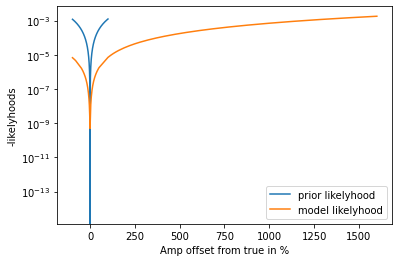

/net/vdesk/data2/ouwehand/lisa/lisa-vdesk-venv/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


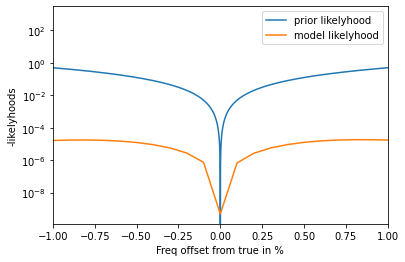

In [87]:
# Plotting amplitude and frequency prior to see if all went well
for i, xlab,true in zip([0,1],["Amplitude","Frequency"],[Amp_true,f_true]):
    x = [np.linspace(1e-18,1e-16,1000000),np.linspace(5e-4,5e-3,1000000)]
    plt.plot((x[i]-true)/true*100,-gauss_prior(x[i],obs_q[i]*obs_qe[i],obs_q[i]),label="prior likelyhood")
    
    if i == 0:
        plt.plot((Amp_var[0]-Amp_true)/Amp_true*100,-Amp_var[1],label="model likelyhood")
        plt.xlabel("Amp offset from true in %")
        plt.ylabel('-likelyhoods')
        plt.yscale('log')
        # plt.xlim(-10,10)
        plt.legend()
        plt.show()
    else:
        plt.plot((f_var[0]-f_true)/f_true*100,-f_var[1],label="model likelyhood")
        plt.xlabel("Freq offset from true in %")
        plt.ylabel('-likelyhoods')
        plt.yscale('log')
        plt.xlim(-1,1)
        plt.legend()
        plt.show()

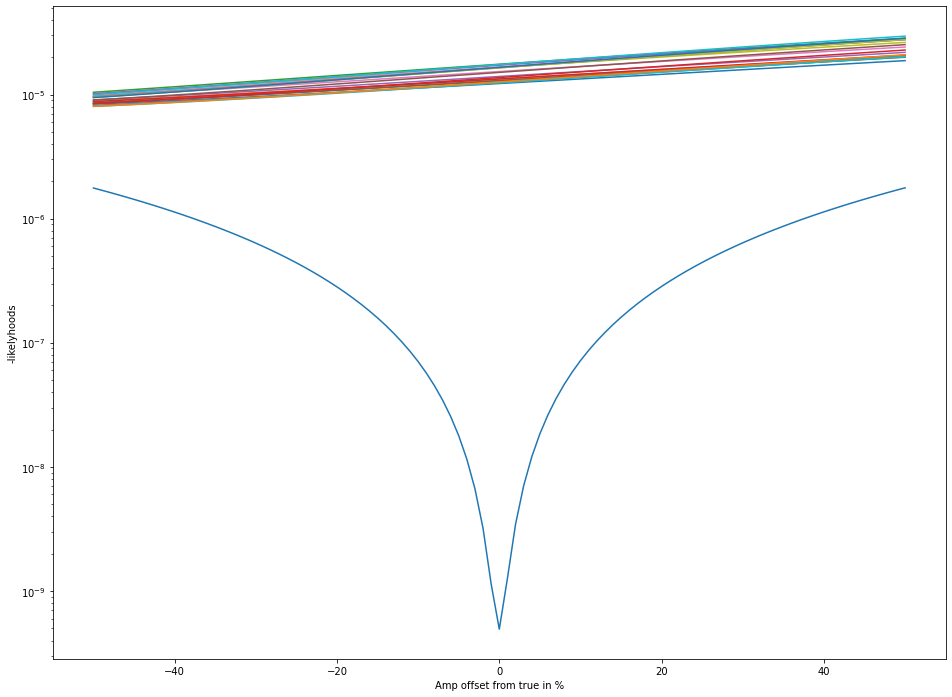

In [21]:
tmp0 = (f_true + 1e-5*np.array(np.linspace(-5,5,21)))
tmp1 = []
plt.figure(figsize=(16,12))
for i in range(len(tmp0)):
    tmp1.append(likelyhoods_Amp(newdat=True,mkfile=False,tight=True,freq=tmp0[i]))
    plt.plot((tmp1[i][0]-Amp_true)/Amp_true*100,-tmp1[i][1],label=str(tmp0[i])+"Hz")
plt.xlabel("Amp offset from true in %")
plt.ylabel('-likelyhoods')
plt.yscale('log')
plt.show()

# Imshow likelyhoods

[array([-5.,  5.]), array([-50.,  50.])]


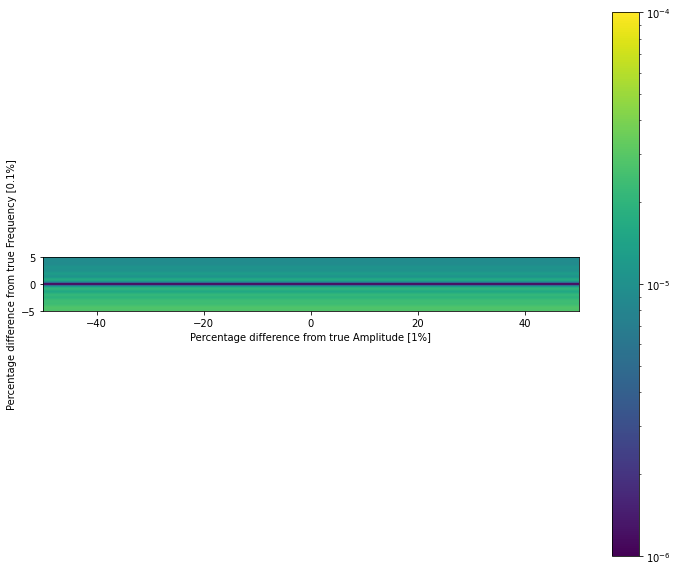

In [82]:
from matplotlib.colors import LogNorm
N = 51
Amp_range = Amp_vartmp = Amp_true + 5e-19*np.array(np.linspace(-50,50,N))
freq_range = (f_true + 1e-5*np.array(np.linspace(-5,5,N)))

model_L_2D = np.zeros((N,N))
for i in range(N):
    A = Amp_range[i]
    for j in range(N):
        f = freq_range[i]
        
        model_L_2D[i,j] = lnL([A,f],fsdata[0],fsdata[1])

ranges = [(np.array([freq_range[0],freq_range[-1]])-f_true)/f_true*100,(np.array([Amp_range[0],Amp_range[-1]])-Amp_true)/Amp_true*100]
print (ranges)

plt.figure(figsize=(12,10))
plt.imshow(-model_L_2D,norm=LogNorm(vmin=1e-6, vmax=1e-4),extent=[*ranges[1],*ranges[0]])#Amp_range[-1],Amp_range[0]])
plt.colorbar()
plt.ylabel("Percentage difference from true Frequency [0.1%]")
plt.xlabel("Percentage difference from true Amplitude [1%]")
plt.show()

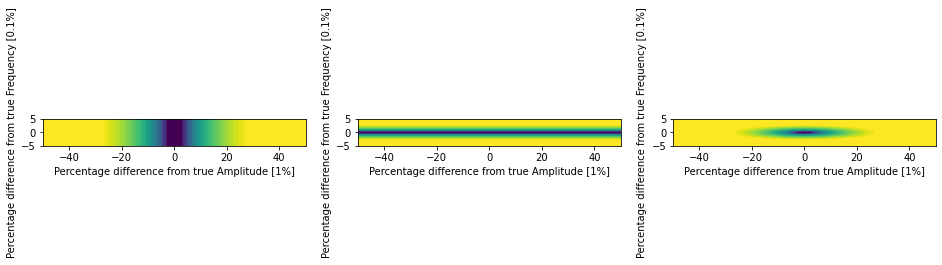

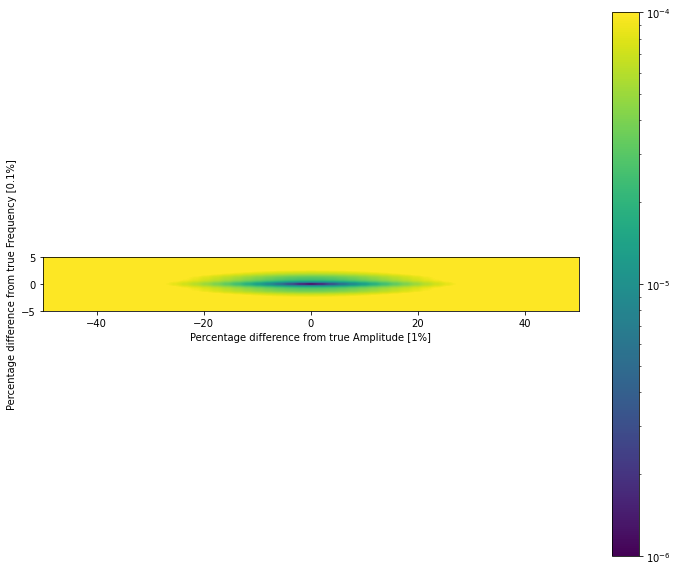

In [83]:

prior_1D_Amp = gauss_prior(Amp_range,obs_q[0]*obs_qe[0],obs_q[0])
prior_2D_Amp = np.array(list(prior_1D_Amp)*N).reshape(N,N)
prior_1D_freq = gauss_prior(freq_range,obs_q[1]*obs_qe[1],obs_q[1])
prior_2D_freq = np.array(list(prior_1D_freq)*N).reshape(N,N).T

fig,axs = plt.subplots(1,3,figsize=(16,4))
axs[0].imshow(-prior_2D_Amp,norm=LogNorm(vmin=1e-6, vmax=1e-4),extent=[*ranges[1],*ranges[0]])
axs[0].set_ylabel("Percentage difference from true Frequency [0.1%]")
axs[0].set_xlabel("Percentage difference from true Amplitude [1%]")

axs[1].imshow(-prior_2D_freq,norm=LogNorm(vmin=1e-6, vmax=1e-4),extent=[*ranges[1],*ranges[0]])
axs[1].set_ylabel("Percentage difference from true Frequency [0.1%]")
axs[1].set_xlabel("Percentage difference from true Amplitude [1%]")


axs[2].imshow(-(prior_2D_freq+prior_2D_Amp),norm=LogNorm(vmin=1e-6, vmax=1e-4),extent=[*ranges[1],*ranges[0]])
axs[2].set_ylabel("Percentage difference from true Frequency [0.1%]")
axs[2].set_xlabel("Percentage difference from true Amplitude [1%]")
plt.show()

plt.figure(figsize=(12,10))
plt.imshow(-(prior_2D_freq+prior_2D_Amp+model_L_2D),norm=LogNorm(vmin=1e-6, vmax=1e-4),extent=[*ranges[1],*ranges[0]])#Amp_range[-1],Amp_range[0]])
plt.colorbar()
plt.ylabel("Percentage difference from true Frequency [0.1%]")
plt.xlabel("Percentage difference from true Amplitude [1%]")
plt.show()

# Now for phase and amplitude!

In [19]:
def lnL(theta, t, y):
    """
    The log likelihood of our simplistic Linear Regression. 
    """
    Amp, f, phi0 = theta
    newt, y_model = model(t,y,*theta)
    
    return -0.5*(np.sum((y-y_model)**2))

[array([-100.,  100.]), array([-50.,  50.])]


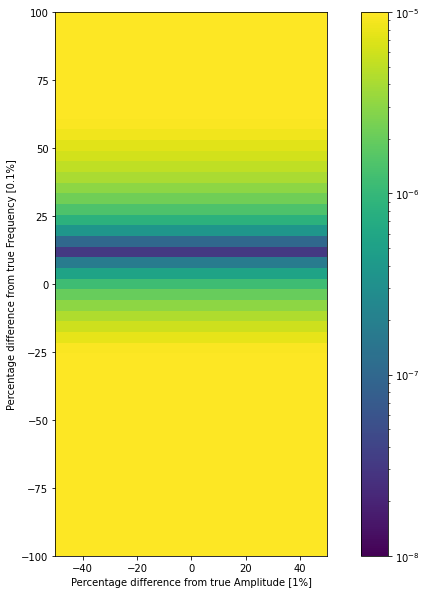

In [26]:
from matplotlib.colors import LogNorm
N = 51
Amp_range = Amp_true + 5e-19*np.linspace(-50,50,N)
phi0_range = np.linspace(-np.pi,np.pi,N)

# model_L_2D = np.zeros((N,N))
# for i in range(N):
#     A = Amp_range[i]
#     for j in range(N):
#         p = phi0_range[i]
        
#         model_L_2D[i,j] = lnL([A,f_true,p],fsdata[0],fsdata[1])

ranges = [(np.array([phi0_range[0],phi0_range[-1]])/np.pi)*100,(np.array([Amp_range[0],Amp_range[-1]])-Amp_true)/Amp_true*100]
print (ranges)

plt.figure(figsize=(12,10))
plt.imshow(-model_L_2D,norm=LogNorm(vmin=1e-8, vmax=1e-5),extent=[*ranges[1],*ranges[0]])#Amp_range[-1],Amp_range[0]])
plt.colorbar()
plt.ylabel("Percentage difference from true Frequency [0.1%]")
plt.xlabel("Percentage difference from true Amplitude [1%]")
plt.show()

/tmp/ipykernel_13832/399649328.py:24: RuntimeWarning: divide by zero encountered in log
  return np.log(gauss)#/np.sqrt(2*np.pi*(sig)**2)


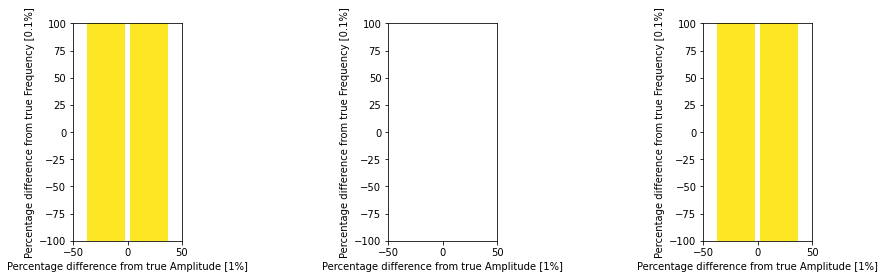

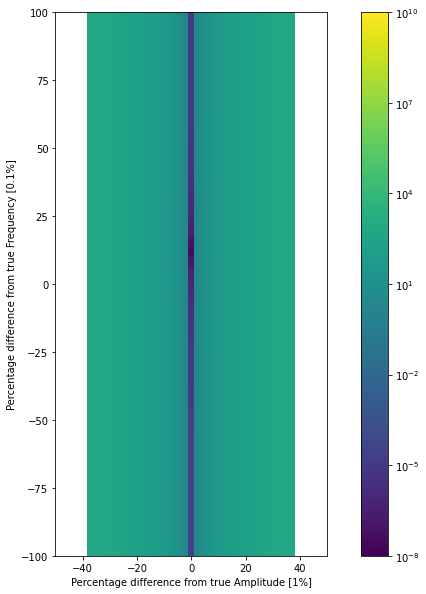

In [30]:

prior_1D_Amp = gauss_prior(Amp_range,obs_q[0]*obs_qe[0],obs_q[0])
prior_2D_Amp = np.array(list(prior_1D_Amp)*N).reshape(N,N)
prior_2D_phi0 = np.zeros((N,N))

fig,axs = plt.subplots(1,3,figsize=(16,4))
axs[0].imshow(-prior_2D_Amp,norm=LogNorm(vmin=1e-8, vmax=1e-4),extent=[*ranges[1],*ranges[0]])
axs[0].set_ylabel("Percentage difference from true Frequency [0.1%]")
axs[0].set_xlabel("Percentage difference from true Amplitude [1%]")

axs[1].imshow(-prior_2D_phi0,norm=LogNorm(vmin=1e-8, vmax=1e-4),extent=[*ranges[1],*ranges[0]])
axs[1].set_ylabel("Percentage difference from true Frequency [0.1%]")
axs[1].set_xlabel("Percentage difference from true Amplitude [1%]")


axs[2].imshow(-(prior_2D_phi0+prior_2D_Amp),norm=LogNorm(vmin=1e-8, vmax=1),extent=[*ranges[1],*ranges[0]])
axs[2].set_ylabel("Percentage difference from true Frequency [0.1%]")
axs[2].set_xlabel("Percentage difference from true Amplitude [1%]")
plt.show()

plt.figure(figsize=(12,10))
plt.imshow(-(prior_2D_phi0+prior_2D_Amp+model_L_2D),norm=LogNorm(vmin=1e-8, vmax=1e10),extent=[*ranges[1],*ranges[0]])#Amp_range[-1],Amp_range[0]])
plt.colorbar()
plt.ylabel("Percentage difference from true Frequency [0.1%]")
plt.xlabel("Percentage difference from true Amplitude [1%]")
plt.show()